Simulate Data
We give an example about fitting an AR(2) model using simulated data. We simulate 200 observations from the following model:

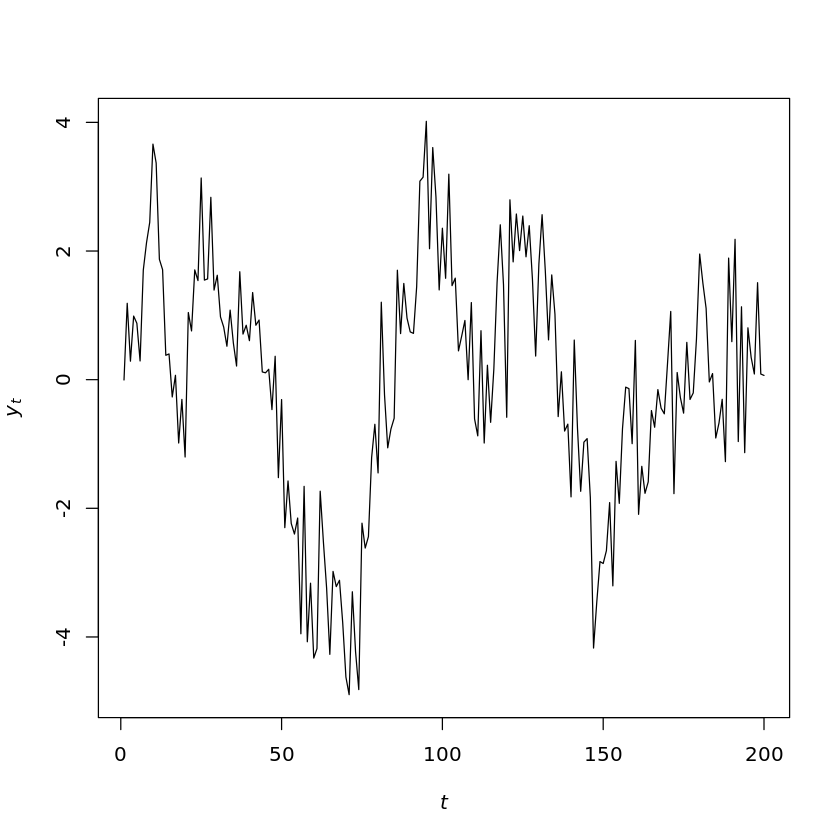

In [1]:
## simulate data

phi1=0.5
phi2=0.4
v=1

set.seed(1)
y.sample=arima.sim(n=200,model=list(order=c(2,0,0),ar=c(phi1,phi2),sd=sqrt(v)))
plot.ts(y.sample,ylab=expression(italic(y)[italic(t)]),xlab=expression(italic(t)),
        main='')

Now, we perform a prior sensitivity analysis for the choice of hyperparameters in prior distribution. We choose three sets of prior hyperparameters and plot the posterior distribution for 
The three sets of prior hyperparameters are shown on the picture


In [6]:
## prior sensitivity analysis
## plot posterior distribution of phi_1 and phi_2 on a grid 

library(colorRamps)
library(leaflet)
library(fields)
library(mvtnorm)

## generate grid
coordinates_1=seq(-3,3,length.out = 100)
coordinates_2=seq(-3,3,length.out = 100)
coordinates=expand.grid(coordinates_1,coordinates_2)
coordinates=as.matrix(coordinates)

## set up
N=100
p=2  ## order of AR process
n.all=length(y.sample) ## T, total number of data

Y=matrix(y.sample[3:n.all],ncol=1)
Fmtx=matrix(c(y.sample[2:(n.all-1)],y.sample[1:(n.all-2)]),nrow=p,byrow=TRUE)
n=length(Y)

## function to compute parameters for the posterior distribution of phi_1 and phi_2
## the posterior distribution of phi_1 and phi_2 is a multivariate t distribution

cal_parameters=function(m0=matrix(c(0,0),nrow=2),C0=diag(2),n0,d0){
  e=Y-t(Fmtx)%*%m0
  Q=t(Fmtx)%*%C0%*%Fmtx+diag(n)
  Q.inv=chol2inv(chol(Q))  ## similar as solve, but more robust
  A=C0%*%Fmtx%*%Q.inv
  m=m0+A%*%e
  C=C0-A%*%Q%*%t(A)
  n.star=n+n0
  d.star=t(Y-t(Fmtx)%*%m0)%*%Q.inv%*%(Y-t(Fmtx)%*%m0)+d0
  
  params=list()
  params[[1]]=n.star
  params[[2]]=d.star
  params[[3]]=m
  params[[4]]=C
  
  return(params)
}


## evaluate density at the grid points
get_density=function(param){
  location=param[[3]]
  scale=as.numeric(param[[2]]/param[[1]])*param[[4]]
  density=rep(0,N^2)
  
  for (i in 1:N^2) {
    xi=coordinates[i,]
    density[i]=dmvt(xi,delta=location,sigma=scale,df=param[[1]])
  }
  
  density_expand=matrix(density,nrow=N)
  return(density_expand)
}

## calculate density for three sets of hyperparameters
params1=cal_parameters(n0=2,d0=2)
params2=cal_parameters(n0=6,d0=1)
params3=cal_parameters(m0=matrix(c(-0.5,-0.5),nrow=2),n0=6,d0=1)

col.list=matlab.like2(N)
Z=list(get_density(params1),get_density(params2),get_density(params3))

op <- par(mfrow = c(1,3),
          oma = c(5,4,0,0) + 0.1,
          mar = c(4,4,0,0) + 0.2)
image(coordinates_1,coordinates_2,Z[[1]],col=col.list,
      zlim=range(unlist(Z)),xlab=expression(phi[1]),ylab=expression(phi[2]))
image(coordinates_1,coordinates_2,Z[[2]],col=col.list,
      zlim=range(unlist(Z)),xlab=expression(phi[1]),ylab=expression(phi[2]))
image(coordinates_1,coordinates_2,Z[[3]],col=col.list,
      zlim=range(unlist(Z)),xlab=expression(phi[1]),ylab=expression(phi[2]))

ERROR: Error in library(leaflet): there is no package called ‘leaflet’


Posterior Inference

In [ ]:
m0=matrix(rep(0,p),ncol=1)
C0=diag(p)
n0=2
d0=2

e=Y-t(Fmtx)%*%m0
Q=t(Fmtx)%*%C0%*%Fmtx+diag(n)
Q.inv=chol2inv(chol(Q))
A=C0%*%Fmtx%*%Q.inv
m=m0+A%*%e
C=C0-A%*%Q%*%t(A)
n.star=n+n0
d.star=t(Y-t(Fmtx)%*%m0)%*%Q.inv%*%(Y-t(Fmtx)%*%m0)+d0


n.sample=5000

nu.sample=rep(0,n.sample)
phi.sample=matrix(0,nrow=n.sample,ncol=p)

for (i in 1:n.sample) {
  set.seed(i)
  nu.new=1/rgamma(1,shape=n.star/2,rate=d.star/2)
  nu.sample[i]=nu.new
  phi.new=rmvnorm(1,mean=m,sigma=nu.new*C)
  phi.sample[i,]=phi.new
}

par(mfrow=c(1,3))
hist(phi.sample[,1],freq=FALSE,xlab=expression(phi[1]),main="",ylim=c(0,6.4))
lines(density(phi.sample[,1]),type='l',col='red')
hist(phi.sample[,2],freq=FALSE,xlab=expression(phi[2]),main="",ylim=c(0,6.4))
lines(density(phi.sample[,2]),type='l',col='red')
hist(nu.sample,freq=FALSE,xlab=expression(nu),main="")
lines(density(nu.sample),type='l',col='red')

Model Checking by In-sample Point and Interval Estimation
To check whether the model fits well, we plot the posterior point and interval estimate for each point.

In [ ]:
## get in sample prediction
post.pred.y=function(s){
  
  beta.cur=matrix(phi.sample[s,],ncol=1)
  nu.cur=nu.sample[s]
  mu.y=t(Fmtx)%*%beta.cur
  sapply(1:length(mu.y), function(k){rnorm(1,mu.y[k],sqrt(nu.cur))})
  
  
}  

y.post.pred.sample=sapply(1:5000, post.pred.y)

In [ ]:
## show the result
summary.vec95=function(vec){
  c(unname(quantile(vec,0.025)),mean(vec),unname(quantile(vec,0.975)))
}

summary.y=apply(y.post.pred.sample,MARGIN=1,summary.vec95)

plot(Y,type='b',xlab='Time',ylab='',ylim=c(-7,7),pch=16)
lines(summary.y[2,],type='b',col='grey',lty=2,pch=4)
lines(summary.y[1,],type='l',col='purple',lty=3)
lines(summary.y[3,],type='l',col='purple',lty=3)
legend("topright",legend=c('Truth','Mean','95% C.I.'),lty=1:3,col=c('black','grey','purple'),
       horiz = T,pch=c(16,4,NA))